In [0]:
import numpy as onp
import jax.numpy as np

import matplotlib.pyplot as plt

In [0]:
from jax import random

In [0]:
key = random.PRNGKey(777)

In [0]:
def generate_samples(num_samples):
  eps = onp.random.normal(size = num_samples)
  x = onp.random.uniform(-10.5, 10.5, num_samples)
  y = 7 * onp.sin(0.75 * x) + 0.5 * x + eps
  return x, y

In [0]:
num_samples = batch_size = 1000
x, y = generate_samples(batch_size)

x, y = x[:, np.newaxis], y[:, np.newaxis]

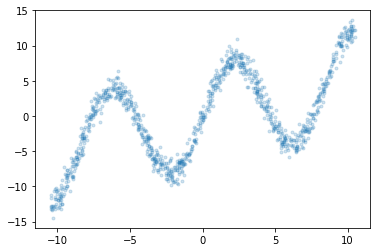

In [6]:
plt.scatter(x, y, marker = ".", alpha = 0.2)
plt.show()

In [0]:
def network(params, inputs):
  h = inputs
  for param in params[:-1]:
    w, b = param[0], param[1]
    h = np.tanh(np.dot(h, w.T) + b)
  w_out, b_out = params[-1][0], params[-1][1]
  return np.dot(h, w_out.T) + b_out

In [0]:
def initialize_mlp(sizes, key):
  keys = random.split(key, len(sizes))
  # why? : to enable quicker direct generation in gpu

  def initialize_layer(m, n, key, scale = 1e-2):
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
  
  return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1: ], keys)]

n_input = 1
n_hidden = 20
n_output = 1

layer_sizes = [n_input, n_hidden, n_output]
params = initialize_mlp(layer_sizes, key)

# the nice thing about defining func like this is... we can increase layers as
# we want to.. layer_sizes = [n_in, n_h1, n_h2, n_h3, n_out]

In [0]:
def loss_fn(params, model, inputs, targets):
  outputs = model(params, inputs)
  errors = outputs - targets
  return np.average(np.square(errors))

In [0]:
from jax.experimental import optimizers
from jax import value_and_grad, jit, vmap, grad

In [0]:
step_size = 0.01
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

In [0]:
def update(params, model, inputs, targets, opt_state):
  values, grads = value_and_grad(loss_fn)(params, model, inputs, targets)
  opt_state = opt_update(0, grads, opt_state)
  return get_params(opt_state), opt_state, values

In [13]:
def train(params, network, x, y, opt_state):
  for epoch in range(1000):
    params, opt_state, loss = update(params, network, x, y, opt_state)
    if not epoch % 100 : print(epoch, loss)
  return params

params = train(params, network, x, y, opt_state)

0 36.71969
100 23.744888
200 22.024391
300 17.615751
400 11.741405
500 7.6808033
600 5.205292
700 3.7024033
800 2.7685375
900 2.1819546


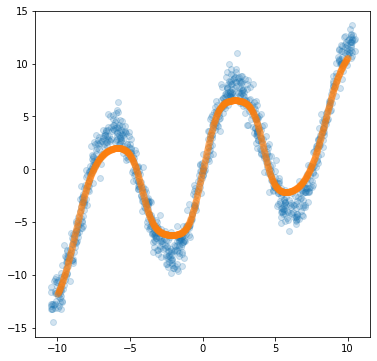

In [18]:
x_test = onp.linspace(-10, 10, num_samples).reshape(batch_size, 1)
y_test = network(params, x_test)

plt.figure(figsize = (6, 6))
plt.scatter(x, y, alpha = 0.2)
plt.scatter(x_test, y_test, alpha = 0.2)
plt.show()

In [0]:
from jax.experimental import stax

from jax.experimental.stax import (Dense, Tanh, Flatten, Relu, LogSoftmax, 
                                   Softmax, Exp)

from jax.scipy.special import logsumexp

from jax.nn import softmax

In [0]:
n_mixture = 5

init_fun, network = stax.serial(Dense(n_hidden), Tanh, Dense(n_mixture * 3))
# coz we need pi_k, mu_k, sigma_k for k = 1..5

def lognormal(y, mean, logstd):
  return -onp.log(onp.sqrt(2 * onp.pi)) - logstd - np.square(y - mean) / (2 * np.exp(logstd)**2)

def get_mdn_coeff(output):
  logmix, mean, logstd = output.split(3, axis = 1)
  logmix = logmix - logsumexp(logmix, axis = 1, keepdims = True) 
  # axis = 1 in both above coz.. output shape is (batch_size, 15)
  return logmix, mean, logstd

def mdn_loss_func(logmix, mean, logstd, y):
  v = logmix + lognormal(y, mean, logstd)
  v = logsumexp(v, axis = 1)
  return -np.mean(v)

In [0]:
def loss_fn(params, model, inputs, targets):
  outputs = network(params, inputs)
  logmix, mean, logstd = get_mdn_coeff(outputs)
  return mdn_loss_func(logmix, mean, logstd, targets)

In [0]:
_, params = init_fun(key, (batch_size, 1))

step_size = 0.01
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

In [34]:
mdn_x = y
mdn_y = x

params = train(params, network, mdn_x, mdn_y, opt_state)

0 5.841728
100 2.5034351
200 2.36369
300 2.278827
400 2.196514
500 2.1229386
600 2.0911422
700 2.0716975
800 2.0029602
900 1.9766463


In [0]:
# lets see how mean varies with mdn_x
x_test = onp.linspace(-15, 15, num_samples).reshape((batch_size, 1))

logmix, mean, logstd = get_mdn_coeff(network(params, x_test))
logmix_data = np.exp(logmix)
sigma_data = np.exp(logstd)

pi_data = softmax(logmix)

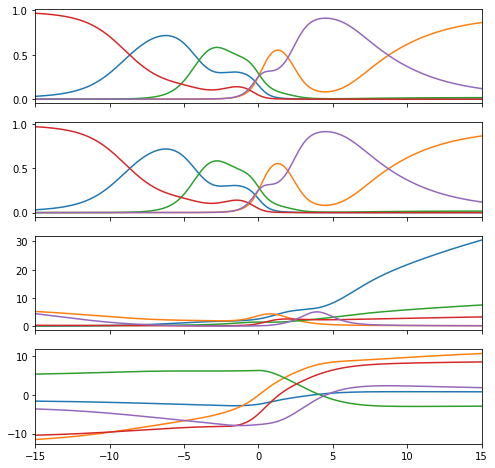

In [44]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex = True, figsize = (8, 8))
ax1.plot(x_test, logmix_data)
ax2.plot(x_test, pi_data)
ax3.plot(x_test, sigma_data)
ax4.plot(x_test, mean)
plt.xlim(-15, 15)
plt.show()

In [0]:
def gumbel_sample(x, axis = 1):
  z = onp.random.gumbel(loc = 0, scale = 1, size = x.shape)
  return (onp.log(x) + z).argmax(axis = axis)

k = gumbel_sample(pi_data)

In [0]:
indices = (onp.arange(num_samples), k)
rn = onp.random.randn(num_samples)
sampled = rn * sigma_data[indices] + mean[indices]

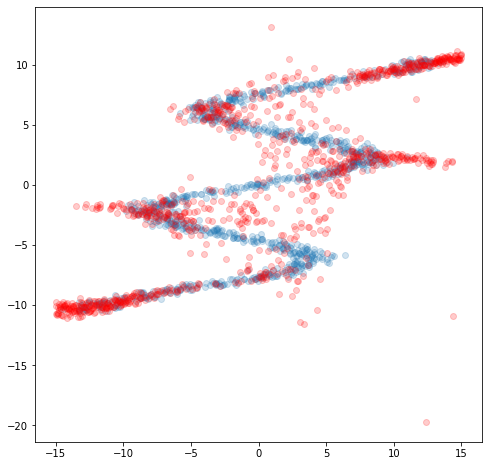

In [53]:
plt.figure(figsize=(8, 8))
plt.scatter(mdn_x, mdn_y, alpha=0.2)
plt.scatter(x_test, sampled, alpha=0.2, color='red')
plt.show()